# Kaggle Titanic survival - feature selection 3 (model backward elimination)

Reducing the number of features we use can have three benefits:

* Simplifies model explanation
* Model fit may be improved by the removal of features that add no value
* Model will be faster to fit

In this notebook we will use a model-based approach whereby we incrementally remove features that least reduce model performance (we could use simple accuracy, but in this case we will use ROC Area Under Curve as a more thorough analysis of performance). If you are not familiar with ROC AUC, have a look at:

https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/06_roc_sensitivity_specificity.ipynb

Two key advantages of this method are:

* It is relatively simple.
* It is tailored to the model in question.

Some key disadvantage of this method are:

* It may be slow if there are many paraemters (though the loop to select features could be limited in the number of features to select).
* The selection of features may be dependent on model meta-parameters (such as level of regularisation).
* The selection of features may not transfer between models (e.g. a model that does not allow for feature interactions may not detect features which do not add much value independently).

The machine learning model we will use to test the feature selection is as previously described:

https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/02_logistic_regression.ipynb

We will also assess performance using k-fold stratification for better measurement of performance. If you are not familiar with k-fold stratification, have a look at:

https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/03_k_fold.ipynb

This method is the mirror image of the method that incrementally adds features. The best features *should* be very similar in both methods, but if both methods are run then it may be best to combine lists of best features if they differ a little. Here is the method for chosing features by incrementally adding those features that lead to best improvement in model performance:

https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/08_feature_selection_2_forward.ipynb

We will go through the following steps:

* Download and save pre-processed data
* Split data into features (X) and label (y)
* Loop through features to select the feature that most increas ROC AUC
* Plot results

https://scikit-learn.org/stable/modules/feature_selection.html#recursive-feature-elimination

In [1]:
# Hide warnings (to keep notebook tidy; do not usually do this)
import warnings
warnings.filterwarnings("ignore")

## Load modules

A standard Anaconda install of Python (https://www.anaconda.com/distribution/) contains all the necessary modules.

In [2]:
import numpy as np
import pandas as pd
# Import machine learning methods
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

## Load data

The section below downloads pre-processed data, and saves it to a subfolder (from where this code is run).
If data has already been downloaded that cell may be skipped.

Code that was used to pre-process the data ready for machine learning may be found at:
https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/01_preprocessing.ipynb

In [3]:
download_required = True

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

In [4]:
data = pd.read_csv('data/processed_data.csv')

The first column is a passenger index number. We will remove this, as this is not part of the original Titanic passenger data.

In [5]:
# Drop Passengerid (axis=1 indicates we are removing a column rather than a row)
# We drop passenger ID as it is not original data

data.drop('PassengerId', inplace=True, axis=1)

## Divide into X (features) and y (lables)

We will separate out our features (the data we use to make a prediction) from our label (what we are truing to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (survvive or not) `y`.

In [6]:
X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'

## Forward feature selection

Define data standardisation function.

In [7]:
def standardise_data(X_train, X_test):
    
    # Initialise a new scaling object for normalising input data
    sc = StandardScaler() 

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_std=sc.transform(X_train)
    test_std=sc.transform(X_test)
    
    return train_std, test_std

The forward selection method:

* Keeps a list of selected features
* Keeps a list of features still available for selection
* Loops through available features:
    * Calculates added value for each feature (using stratified k-fold validation)
    * Selects feature that adds most value
    * Adds selected feature to *selected features* list and removes it from *available features* list
    
This methos uses a `while` lop to keep exploring features until no more are available. An alternative would be to use a `for` loop with a maximum number of features to select.

In [8]:
# Create list to store accuracies and chosen features
roc_auc_by_feature_number = []
chosen_features = []

# Initialise chosen features list and run tracker
available_features = list(X)
run = 0
number_of_features = len(list(X))

# Creat einitial reference performance
reference_auc = 1.0 # used to compare reduction in AUC

# Loop through feature list to select next feature
while len(available_features)> 1:

    # Track and pront progress
    run += 1
    print ('Feature run {} of {}'.format(run, number_of_features-1))
    
    # Convert DataFrames to NumPy arrays
    y_np = y.values
    
    # Reset best feature and accuracy
    best_result = 1.0
    best_feature = ''

    # Loop through available features
    for feature in available_features:

        # Create copy of already chosen features to avoid orginal being changed
        features_to_use = available_features.copy()
        # Create a list of features to use by removing 1 feature
        features_to_use.remove(feature)
        # Get data for features, and convert to NumPy array
        X_np = X[features_to_use].values
        
        # Set up lists to hold results for each selected features
        test_auc_results = []
    
        # Set up k-fold training/test splits
        number_of_splits = 5
        skf = StratifiedKFold(n_splits = number_of_splits)
        skf.get_n_splits(X_np, y)
    
        # Loop through the k-fold splits
        for train_index, test_index in skf.split(X_np, y_np):
            
            # Get X and Y train/test
            X_train, X_test = X_np[train_index], X_np[test_index]
            y_train, y_test = y[train_index], y[test_index]
    
            # Get X and Y train/test
            X_train_std, X_test_std = standardise_data(X_train, X_test)
    
            # Set up and fit model
            model = LogisticRegression(solver='lbfgs')
            model.fit(X_train_std,y_train)
    
            # Predict test set labels
            y_pred_test = model.predict(X_test_std)
            
            # Calculate accuracy of test sets
            accuracy_test = np.mean(y_pred_test == y_test)
          
            # Get ROC AUC
            probabilities = model.predict_proba(X_test_std)
            probabilities = probabilities[:, 1] # Probability of 'survived'
            fpr, tpr, thresholds = roc_curve(y_test, probabilities)
            roc_auc = auc(fpr, tpr)
            test_auc_results.append(roc_auc)
        
        # Get average result from all k-fold splits
        feature_auc = np.mean(test_auc_results)
    
        # Update chosen feature and result if this feature is a new best
        # We are looking for the smallest drop in performance
        drop_in_performance = reference_auc - feature_auc
        if drop_in_performance < best_result:
            best_result = drop_in_performance
            best_feature = feature
            best_auc = feature_auc
                
    # k-fold splits are complete    
    # Add mean accuracy and AUC to record of accuracy by feature number
    roc_auc_by_feature_number.append(best_auc)
    chosen_features.append(best_feature)    
    available_features.remove(best_feature)
    reference_auc = best_auc

# Add last remaining feature
chosen_features += available_features
roc_auc_by_feature_number.append(0)
    
# Put results in DataFrame
# Reverse order of lists with [::-1] so best features first
results = pd.DataFrame()
results['feature removed'] = chosen_features[::-1]
results['ROC AUC'] = roc_auc_by_feature_number[::-1]

Feature run 1 of 23
Feature run 2 of 23
Feature run 3 of 23
Feature run 4 of 23
Feature run 5 of 23
Feature run 6 of 23
Feature run 7 of 23
Feature run 8 of 23
Feature run 9 of 23
Feature run 10 of 23
Feature run 11 of 23
Feature run 12 of 23
Feature run 13 of 23
Feature run 14 of 23
Feature run 15 of 23
Feature run 16 of 23
Feature run 17 of 23
Feature run 18 of 23
Feature run 19 of 23
Feature run 20 of 23
Feature run 21 of 23
Feature run 22 of 23
Feature run 23 of 23


### Show results
The table is now in the order of preferred features, though our code worked in the reverse direction, incrementally removing the feature that made least difference to the model.

In [9]:
results

,feature removed,ROC AUC
0,male,0.000000
1,Pclass,0.766733
2,Age,0.833036
3,SibSp,0.843055
4,Embarked_S,0.848686
5,CabinNumberImputed,0.853125
6,CabinLetter_C,0.855046
7,CabinLetter_missing,0.855504
8,CabinLetterImputed,0.855506
9,Embarked_missing,0.855533


### Plot results

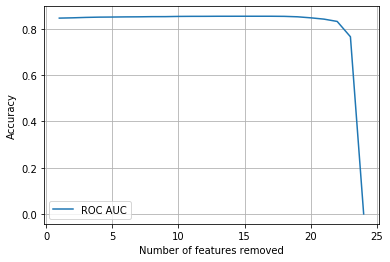

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

chart_x = list(range(1, number_of_features+1))

plt.plot(chart_x, roc_auc_by_feature_number,
        label = 'ROC AUC')

plt.xlabel('Number of features removed')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

From the above results it looks like we could eliminate all but 5-6 features in this model. It may also be worth examining the same method using other performance scores (such as simple accuracy, or f1) in place of ROC AUC.